In [ ]:
# !pip install opencv-python

In [ ]:
# !pip install pillow

In [1]:
import numpy as np
import cv2
from PIL import Image
import time
import pickle
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [2]:
class Cube:
    def __init__(self,size):
        self.size = size
        self.x = np.random.randint(0, self.size)
        self.y = np.random.randint(0, self.size)
        
    def __str__(self):
        return f'{self.x},{self.y}'
    
    def __sub__(self,other):
        return (self.x-other.x,self.y-other.y)
    
    def __eq__(self,other):
        return self.x == other.x and self.y == other.y
    
    def action(self,choise):
        if choise == 0 :
            self.move(x=1, y=1)
        elif choise == 1 :
            self.move(x=-1, y=1)
        elif choise == 2 :
            self.move(x=1, y=-1)
        elif choise == 3 :
            self.move(x=-1, y=-1)
        elif choise == 4 :
            self.move(x=0, y=1)        
        elif choise == 5 :
            self.move(x=0, y=-1) 
        elif choise == 6 :
            self.move(x=1, y=0) 
        elif choise == 7 :
            self.move(x=-1, y=0)             
        elif choise == 8 :
            self.move(x=0, y=0)             
            
    def move(self,x=False,y=False):
        if not x:
            self.x += np.random.randint(-1,2)
        else:
            self.x += x
            
        if not y:
            self.y += np.random.randint(-1,2)
        else:
            self.y += y   
            
        if self.x < 0 :
            self.x = 0
        elif self.x >= self.size :
            self.x = self.size -1

        if self.y < 0 :
            self.y = 0
        elif self.y >= self.size :
            self.y = self.size -1

In [3]:
class envCube:
    SIZE = 10
    OBSERVATION_SPACE_VALUES = (SIZE,SIZE,3)
    ACTION_SPACE_VALUES = 9
    RETURN_IMAGE = True
    
    FOOD_REWARD = 25
    ENEMY_PENALITY = -300
    MOVE_PENALITY = -1    
    
    d = {1:(255,0,0), #blue
         2:(0,255,0), #green
         3:(0,0,255)} #red

    PLAYER_N = 1
    FOOD_N =2
    ENEMY_N =3    
    
    def reset(self):
        self.player = Cube(self.SIZE)
        self.food = Cube(self.SIZE)
        while self.food == self.player:
            self.food = Cube(self.SIZE)
        
        self.enemy = Cube(self.SIZE)
        while self.enemy == self.player or self.enemy == self.food:
            self.enemy = Cube(self.SIZE)
        
        if self.RETURN_IMAGE:
            observation = np.array(self.get_image())
        else:
            observation = (self.player - self.food)+(self.player - self.enemy) 
        
        self.episode_step = 0
        
        return observation
    
    def step(self,action):
        self.episode_step += 1
        self.player.action(action)
        self.food.move()
        self.enemy.move()

        if self.RETURN_IMAGE:
            new_observation = np.array(self.get_image())
        else:
            new_observation = (self.player - self.food)+(self.player - self.enemy)

        if self.player == self.food :
            reward = self.FOOD_REWARD
        elif self.player == self.enemy :
            reward = self.ENEMY_PENALITY
        else:
            reward = self.MOVE_PENALITY

        done = False
        if self.player == self.food or self.player == self.enemy or self.episode_step>=200:
            done = True
        
        return new_observation,reward,done
    
    def render(self):
        img = self.get_image()       
        img = img.resize((800,800))
        cv2.imshow('Predator',np.array(img))
        cv2.waitKey(1)
    
    def get_image(self):
        env = np.zeros((self.SIZE,self.SIZE,3), dtype=np.uint8)
        env[self.food.x][self.food.y] = self.d[self.FOOD_N]
        env[self.player.x][self.player.y] = self.d[self.PLAYER_N]
        env[self.enemy.x][self.enemy.y] = self.d[self.ENEMY_N]
        img = Image.fromarray(env,'RGB')
        return img

    def get_qtable(self,qtable_name=None):
        if qtable_name is None:
            q_table = {}
            for x1 in range(-self.SIZE+1, self.SIZE):
                for y1 in range(-self.SIZE+1, self.SIZE):
                    for x2 in range(-self.SIZE+1, self.SIZE):
                        for y2 in range(-self.SIZE+1, self.SIZE):
                            q_table[(x1,y1,x2,y2)] = [np.random.uniform(-5,0) for i in range(self.ACTION_SPACE_VALUES)]
        else:
            with open(qtable_name,'rb') as f:
                q_table=pickle.load(f)
        return q_table

In [14]:
# Own Tensorboard class
# Here is an updated working code for TensorFlow 2.4.1, just copy and paste it as it is :
import tensorflow as tf
import os
from tensorflow.keras.callbacks import TensorBoard
class ModifiedTensorBoard(TensorBoard):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        self.writer = tf.summary.create_file_writer(self.log_dir)
        self._log_write_dir = self.log_dir

    def set_model(self, model):
        self.model = model

        self._train_dir = os.path.join(self._log_write_dir, 'train')
        self._train_step = self.model._train_counter

        self._val_dir = os.path.join(self._log_write_dir, 'validation')
        self._val_step = self.model._test_counter

        self._should_write_train_graph = False

    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    def on_batch_end(self, batch, logs=None):
        pass

    def on_train_end(self, _):
        pass

    def update_stats(self, **stats):
        with self.writer.as_default():
            for key, value in stats.items():
                tf.summary.scalar(key, value, step = self.step)
                self.writer.flush()

In [15]:
env = envCube()

REPLAY_MEMORY_SIZE = 20000
MINI_REPLAY_MEMORY_SIZE = 64
UPDATE_TARGET_MODE_EVERY = 20
EPISODES = 50000
DISCOUNT = 0.95
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten
from collections import deque
import random

In [16]:
class DQNAgent():
    def __init__(self):
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
        
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.update_target_modle_counter = 0
        
        self.tensorboard = ModifiedTensorBoard(log_dir=f'./logs/dqn_model_{int(time.time())}')
        
    
    def create_model(self):
        model = Sequential()
        model.add(Conv2D(32,(3,3),activation='relu',input_shape=env.OBSERVATION_SPACE_VALUES))
        model.add(Conv2D(32,(3,3),activation='relu'))
        model.add(Flatten())
        model.add(Dense(32,activation='relu'))
        model.add(Dense(env.ACTION_SPACE_VALUES,activation='linear'))
        model.compile(loss='mse',optimizer='Adam',metrics=['accuracy'])
        return model
    
    def train(self,terminal_state):
        if len(self.replay_memory) < REPLAY_MEMORY_SIZE:
            return
        
        minibatch = random.sample(self.replay_memory,MINI_REPLAY_MEMORY_SIZE)
        
        X = []
        y = []
        
        obs_current = np.array([transition[0] for transition in minibatch])/255
        q_values_current = self.model.predict(obs_current)
        
        X = obs_current
        
        obs_new = np.array([transition[3] for transition in minibatch])/255
        q_values_future = self.target_model.predict(obs_new)
        
        for index,(obs,action,reward,new_obs,done) in enumerate(minibatch):
#             X.append(obs)
            if not done:
                yt = reward + DISCOUNT * np.max(q_values_future[index])
            else:
                yt = reward
            
            q_values_current_index = q_values_current[index]
            q_values_current_index[action] = yt
            y.append(q_values_current_index)
        
        self.model.fit(np.array(X),np.array(y),batch_size=MINI_REPLAY_MEMORY_SIZE,shuffle=False,verbose=0,callbacks=[self.tensorboard] if terminal_state else None)
        
        if terminal_state :
            self.update_target_modle_counter += 1
        
        if self.update_target_modle_counter > UPDATE_TARGET_MODE_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.update_target_modle_counter = 0
    
    def update_replay_memory(self,transition):
        return self.replay_memory.append(transition)
    
    def action_q_values_predict(self,obs):
        return self.model.predict(np.array(obs).reshape(-1,*obs.shape))[0]

In [17]:
EPI_DECAY = 0.995
MIN_EPISILON = 0.001
SHOW_EVERY = 10
STATITICS_EVERY = 10

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

episode:0,episode_reward:-383,episilon: 1.0000
episode:1,episode_reward:-301,episilon: 0.9950
episode:2,episode_reward:0,episilon: 0.9900
episode:3,episode_reward:-323,episilon: 0.9851
episode:4,episode_reward:-34,episilon: 0.9801
episode:5,episode_reward:-56,episilon: 0.9752
episode:6,episode_reward:-12,episilon: 0.9704
episode:7,episode_reward:-337,episilon: 0.9655
episode:8,episode_reward:-350,episilon: 0.9607
episode:9,episode_reward:-39,episilon: 0.9559
avg_reward:-183.5,max_reward0,min_reward:-383
INFO:tensorflow:Assets written to: ./modes/-183.500_1640100815.model/assets
episode:10,episode_reward:-307,episilon: 0.9511
episode:11,episode_reward:-78,episilon: 0.9464
episode:12,episode_reward:-344,episilon: 0.9416
episode:13,episode_reward:-419,episilon: 0.9369
episode:14,episode_reward:-382,episilon: 0.9322
episode:15,episode_reward:-459,episilon: 0.9276
episode:16,episode_reward:-338,episilon: 0.9229
episode:17,episode_reward:-157,episilon: 0.9183
episode:18,episode_reward:-164,e

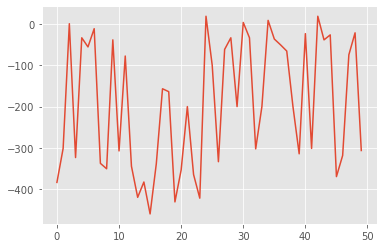

In [19]:
agent = DQNAgent()
episilon = 1
episode_rewards = []
model_save_avg_reward = -200
for episode in range(EPISODES):
    obs = env.reset()
    done = False
    episode_reward = 0
    while not done:
        if np.random.random() > episilon:
            action = np.argmax(agent.action_q_values_predict(obs))
        else:
            action = np.random.randint(0,env.ACTION_SPACE_VALUES)
        
        new_obs,reward,done= env.step(action)
        transition = (obs,action,reward,new_obs,done)
        agent.update_replay_memory(transition)
        agent.train(done)
        
        obs = new_obs
        
        episode_reward += reward
        
        if episode % SHOW_EVERY ==0:
            env.render()
            
    if episode % STATITICS_EVERY ==0 and episode > 0:
        avg_reward = sum(episode_rewards[-STATITICS_EVERY:])/len(episode_rewards[-STATITICS_EVERY:])
        max_reward = max(episode_rewards[-STATITICS_EVERY:])
        min_reward = min(episode_rewards[-STATITICS_EVERY:])
        print(f'avg_reward:{avg_reward},max_reward{max_reward},min_reward:{min_reward}')
        
        agent.tensorboard.update_stats(avg_reward=avg_reward,max_reward=max_reward,min_reward=min_reward,episilon=episilon)
        
        if avg_reward > model_save_avg_reward:
            agent.model.save(f'./modes/{avg_reward:7.3f}_{int(time.time())}.model')
            model_save_avg_reward = avg_reward    
            
    print(f'episode:{episode},episode_reward:{episode_reward},episilon:{episilon:7.4f}')
    episode_rewards.append(episode_reward)
    
    episilon *= EPI_DECAY
    episilon = max(episilon,MIN_EPISILON)
    
plt.plot([i for i in range(len(episode_rewards))],episode_rewards)
plt.show()

In [ ]:
minibatch = random.sample(agent.replay_memory,MINI_REPLAY_MEMORY_SIZE)

In [ ]:
agent = DQNAgent()
obs = env.reset()
agent.action_q_values_predict(obs)

In [ ]:
agent = DQNAgent()
agent.train(False)

In [ ]:
for index,(obs,action,reward,new_obs,done) in enumerate(agent.replay_memory):
    print(f'index:{index},action:{action},reward:{reward}')